# LucusRAG Evaluation: Precision & Recall at Different K Values

This notebook evaluates the RAG system's retrieval performance using precision and recall metrics at various top-k values.

## Metrics
- **Precision@k**: What fraction of retrieved documents are relevant?
- **Recall@k**: What fraction of relevant documents were retrieved?
- **F1@k**: Harmonic mean of precision and recall
- **MRR (Mean Reciprocal Rank)**: How early does the first relevant document appear?
- **NDCG@k**: Normalized Discounted Cumulative Gain (considers ranking quality)


In [1]:
import sys
import os
import json
import asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
from typing import List, Dict, Set, Tuple
from collections import defaultdict

# Configure logging to show in terminal/notebook
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[
        logging.StreamHandler(),  # Output to terminal/notebook
    ]
)

# Set log level for specific modules to see detailed logs
logging.getLogger('rag.engine.retrievers').setLevel(logging.DEBUG)  # Show graph expansion details
logging.getLogger('rag.indexer.orchestrator').setLevel(logging.INFO)  # Show build/refresh progress
logging.getLogger('rag.db.graph_db').setLevel(logging.INFO)  # Show Neo4j operations

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from dotenv import load_dotenv
load_dotenv()

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load Test Queries


In [2]:
# Load test queries with ground truth
with open('test_queries.json', 'r') as f:
    test_queries = json.load(f)

print(f"Loaded {len(test_queries)} test queries")
print("\nQuery categories:")
categories = defaultdict(int)
for q in test_queries:
    categories[q['category']] += 1
for cat, count in categories.items():
    print(f"  {cat}: {count} queries")


Loaded 30 test queries

Query categories:
  data_model: 1 queries
  database: 1 queries
  provider_usage: 1 queries
  providers: 1 queries
  utility: 1 queries
  configuration: 1 queries
  error_handling: 1 queries
  prompts: 1 queries
  parsing: 1 queries
  formatting: 1 queries
  embeddings: 1 queries
  query_pipeline: 1 queries
  vector_config: 1 queries
  parsing_flow: 1 queries
  ast_building: 1 queries
  llm_providers: 1 queries
  progress_tracking: 1 queries
  orchestration: 1 queries
  document_processing: 1 queries
  data_ingestion: 1 queries
  ast_pipeline: 1 queries
  end_to_end_indexing: 1 queries
  query_execution_flow: 1 queries
  embedding_pipeline: 1 queries
  schema_management: 1 queries
  resilience: 1 queries
  element_lifecycle: 1 queries
  configuration_system: 1 queries
  error_handling_system: 1 queries
  provider_patterns: 1 queries


## 2. Initialize RAG System


In [4]:
from rag.indexer.orchestrator import CodeGraphIndexer
from rag.engine.engine import make_query_engine
from rag.schemas.vector_config import VectorIndexConfig
from rag.indexer.vector_indexer import create_vector_index_from_existing_nodes 



# Verify environment configuration
print("Environment Configuration:")
print(f"  LLM_PROVIDER: {os.getenv('LLM_PROVIDER', 'NOT SET (will default to anthropic)')}")
print(f"  LLM_MODEL: {os.getenv('LLM_MODEL', 'NOT SET (will use default)')}")
print(f"  EMBEDDING_PROVIDER: {os.getenv('EMBEDDING_PROVIDER', 'NOT SET (will default to voyage)')}")
print(f"  LLM_MAX_OUTPUT_TOKENS: {os.getenv('LLM_MAX_OUTPUT_TOKENS', 'NOT SET (will default to 768)')}")
os.environ["RETRIEVER_TYPE"] = "bm25_graph_vector_rrf_reranked"
print(f"  RETRIEVER_TYPE: {os.getenv('RETRIEVER_TYPE', 'NOT SET (will default to vector)')}")
print()




Environment Configuration:
  LLM_PROVIDER: openai
  LLM_MODEL: gpt-4o-mini
  EMBEDDING_PROVIDER: openai
  LLM_MAX_OUTPUT_TOKENS: 756
  RETRIEVER_TYPE: bm25_graph_vector_rrf_reranked



In [5]:
algo = os.environ["RETRIEVER_TYPE"]
print("================", algo)
SAVE_TO="~/Documents/"
ALGORITHM = algo
# Save detailed results
from pathlib import Path

# Expand ~ to home directory
des = Path(SAVE_TO).expanduser() / ALGORITHM
des.mkdir(parents=True, exist_ok=True)
print(f"{des} created or already exists")

================ bm25_graph_vector_rrf_reranked
/home/sam/Documents/bm25_graph_vector_rrf_reranked created or already exists


In [6]:
# Initialize the indexer - resolve AST cache directory relative to notebook location
# The .env has AST_CACHE_DIR=ast_cache/results_tree-sitter (relative to project root)
# Notebook is in evaluation/ so we need to resolve it relative to project root
ast_cache_env = os.getenv('AST_CACHE_DIR', 'ast_cache/results_tree-sitter')
if not os.path.isabs(ast_cache_env):
    # If relative path, resolve from project root (parent of evaluation/)
    ast_cache_dir = str(project_root / ast_cache_env)
else:
    ast_cache_dir = ast_cache_env

print(f"Using AST cache directory: {ast_cache_dir}")
print(f"Directory exists: {os.path.exists(ast_cache_dir)}")
if os.path.exists(ast_cache_dir):
    print(f"Files in cache: {len(list(Path(ast_cache_dir).glob('*.json')))}")
print()

indexer = CodeGraphIndexer(ast_cache_dir=ast_cache_dir, top_k=20)
await indexer.build()

2025-11-12 17:17:45,120 - rag.indexer.orchestrator - INFO - Cold build started.....
2025-11-12 17:17:45,121 - rag.indexer.vector_indexer - INFO - Configuring LlamaIndex Settings....
2025-11-12 17:17:45,226 - rag.indexer.vector_indexer - INFO - LlamaIndex Settings configured. Provider: openai, Model: gpt-4o-mini
2025-11-12 17:17:45,226 - rag.indexer.orchestrator - INFO - Building graph structure (nodes + relationships + populate if empty)...
2025-11-12 17:17:45,229 - rag.db.graph_db - INFO - Connected to Neo4j at bolt://localhost:7687
2025-11-12 17:17:45,232 - rag.ingestion.data_loader - INFO - Scanning AST directory: /home/sam/WorkSpace/lucusrag/ast_cache/results_tree-sitter
2025-11-12 17:17:45,233 - rag.ingestion.data_loader - INFO - Found 76 JSON files (before filtering)
2025-11-12 17:17:45,234 - rag.ingestion.data_loader - INFO - Processing 75 code element files
2025-11-12 17:17:45,238 - rag.ingestion.data_loader - INFO - Successfully processed 75 documents
2025-11-12 17:17:45,238 -

Using AST cache directory: /home/sam/WorkSpace/lucusrag/ast_cache/results_tree-sitter
Directory exists: True
Files in cache: 76



2025-11-12 17:17:45,382 - rag.indexer.vector_indexer - INFO - Added 62 additional nodes from Neo4j to docstore
2025-11-12 17:17:45,384 - rag.indexer.vector_indexer - INFO - Hydrated docstore with 137 total nodes for keyword retrievers.
2025-11-12 17:17:45,387 - rag.indexer.vector_indexer - INFO - Index created. Docstore manually attached with 137 nodes for BM25.
2025-11-12 17:17:45,387 - rag.indexer.vector_indexer - INFO - Vector index created successfully from existing nodes
2025-11-12 17:17:45,387 - rag.indexer.orchestrator - INFO - Vector index created successfully!!!
2025-11-12 17:17:45,404 - rag.indexer.orchestrator - INFO - Manifest files updated successfully!!!
2025-11-12 17:17:45,405 - rag.engine.engine - INFO - Using retriever type: bm25_graph_vector_rrf_reranked ===============================
2025-11-12 17:17:45,447 - bm25s - DEBUG - Building index from IDs objects
2025-11-12 17:17:46,795 - rag.indexer.orchestrator - INFO - Cold build successfully finished in 1.67s


BuildResult(documents=75, elapsed_s=1.6739324920345098, mode=<Mode.BUILD: 'build'>, schema_version=1)

In [7]:
print(f"  RETRIEVER_TYPE: {os.getenv('RETRIEVER_TYPE', 'NOT SET (will default to vector)')}")

  RETRIEVER_TYPE: bm25_graph_vector_rrf_reranked


## 3. Define Evaluation Metrics


In [8]:
def precision_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate precision@k: fraction of retrieved docs that are relevant."""
    if k == 0 or len(retrieved) == 0:
        return 0.0
    retrieved_k = retrieved[:k]
    relevant_retrieved = sum(1 for doc in retrieved_k if doc in relevant)
    return relevant_retrieved / len(retrieved_k)

def recall_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate recall@k: fraction of relevant docs that were retrieved."""
    if len(relevant) == 0:
        return 0.0
    retrieved_k = retrieved[:k]
    relevant_retrieved = sum(1 for doc in retrieved_k if doc in relevant)
    return relevant_retrieved / len(relevant)

def f1_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate F1@k: harmonic mean of precision and recall."""
    p = precision_at_k(retrieved, relevant, k)
    r = recall_at_k(retrieved, relevant, k)
    if p + r == 0:
        return 0.0
    return 2 * (p * r) / (p + r)

def mean_reciprocal_rank(retrieved: List[str], relevant: Set[str]) -> float:
    """Calculate MRR: 1/rank of first relevant document."""
    for i, doc in enumerate(retrieved, 1):
        if doc in relevant:
            return 1.0 / i
    return 0.0

def dcg_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate Discounted Cumulative Gain@k."""
    dcg = 0.0
    for i, doc in enumerate(retrieved[:k], 1):
        relevance = 1.0 if doc in relevant else 0.0
        dcg += relevance / np.log2(i + 1)
    return dcg

def ndcg_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate Normalized DCG@k."""
    dcg = dcg_at_k(retrieved, relevant, k)
    # Ideal DCG: all relevant docs at the top
    ideal_retrieved = [1] * min(len(relevant), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(len(ideal_retrieved)))
    if idcg == 0:
        return 0.0
    return dcg / idcg

print("Evaluation metrics defined successfully")


Evaluation metrics defined successfully


## 4. Retrieval Function


In [9]:
# Use orchestrator's retrieve_documents method
async def retrieve_documents(query: str, k: int = 20) -> List[Dict]:
    """Retrieve top-k documents for a query using the orchestrator.
    
    Returns list of dicts with:
    - node_id: unique identifier
    - file_path: source file
    - element_type: type of code element
    - element_name: name of code element
    - score: similarity score
    - text: document content preview
    """
    return await indexer.retrieve_documents(query, k=k)

print("Retrieval function ready")


Retrieval function ready


## 5. Run Evaluation

This cell runs the evaluation across all test queries at multiple k values.


In [10]:
# K values to test
k_values = [1, 3, 5, 10, 15, 20]

# Storage for results
all_results = []

print("Running evaluation...\n")

for i, query_data in enumerate(test_queries, 1):
    query = query_data['query']
    relevant_elements = set(query_data['relevant_elements'])
    category = query_data['category']
    
    # Retrieve documents (max k=20)
    retrieved = await retrieve_documents(query, k=max(k_values))
    
    # Extract element names - deduplicate to handle graph expansion duplicates
    # Use element_name from metadata if available, otherwise parse from text
    retrieved_elements = []
    seen_elements = set()  # Track seen elements to avoid duplicates
    
    for r in retrieved:
        # Try to use element_name from metadata first
        name = r.get('element_name')
        
        # If element_name is missing or 'unknown', parse from text
        if not name or name == 'unknown':
            text = r.get('text', '')
            for line in text.split('\n')[:3]:
                if line.startswith('Name: '):
                    name = line.replace('Name: ', '').strip()
                    break
        
        # Only add if we have a valid name and haven't seen it before
        if name and name != 'unknown' and name not in seen_elements:
            retrieved_elements.append(name)
            seen_elements.add(name)
    
    print(f"Query {i}: Retrieved {len(retrieved_elements)} unique elements (from {len(retrieved)} total results)")
    
    # Calculate metrics for each k
    for k in k_values:
        # Element-level metrics
        p_elem = precision_at_k(retrieved_elements, relevant_elements, k)
        r_elem = recall_at_k(retrieved_elements, relevant_elements, k)
        f1_elem = f1_at_k(retrieved_elements, relevant_elements, k)
        ndcg_elem = ndcg_at_k(retrieved_elements, relevant_elements, k)
        
        all_results.append({
            'query': query,
            'category': category,
            'k': k,
            'precision_elements': p_elem,
            'recall_elements': r_elem,
            'f1_elements': f1_elem,
            'ndcg_elements': ndcg_elem,
        })
    
    # MRR (independent of k)
    mrr_elem = mean_reciprocal_rank(retrieved_elements, relevant_elements)
    print(f"  MRR (elements): {mrr_elem:.3f}")
    print()

# Convert to DataFrame
df_results = pd.DataFrame(all_results)
print(f"\nEvaluation complete! Analyzed {len(test_queries)} queries at {len(k_values)} k values.")
df_results.head(10)


Running evaluation...



2025-11-12 17:17:56,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:17:56,388 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.providers.embeddings.EmbeddingLike', 'rag.providers.embeddings.EmbeddingLike', 'rag.query_processor.process_query']...
2025-11-12 17:17:56,448 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 97 total nodes. Added 37 related nodes (from 37 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 1: Retrieved 14 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:17:59,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:17:59,832 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.providers.embeddings.EmbeddingLike', 'rag.providers.embeddings.EmbeddingLike', 'rag.ast.builders.TreeSitterParser']...
2025-11-12 17:17:59,884 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 90 total nodes. Added 30 related nodes (from 30 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 2: Retrieved 10 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:02,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:02,318 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.ast.ast_builder.analyze_and_store_python_files', 'rag.providers.llms.get_llm', 'rag.providers.llms.LLMProvider']...
2025-11-12 17:18:02,379 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 99 total nodes. Added 39 related nodes (from 39 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 3: Retrieved 13 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:04,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:04,641 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.providers.embeddings.EmbeddingLike', 'rag.providers.embeddings.EmbeddingLike', 'rag.query_processor.process_query']...
2025-11-12 17:18:04,693 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 93 total nodes. Added 33 related nodes (from 33 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 4: Retrieved 11 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:07,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:07,418 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.schemas.progress_tracker.ProgressTracker', 'rag.schemas.progress_tracker.ProgressTracker', 'rag.providers.embeddings.EmbeddingLike']...
2025-11-12 17:18:07,477 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 99 total nodes. Added 39 related nodes (from 39 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 5: Retrieved 13 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:09,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:09,884 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.indexer.vector_indexer.create_vector_index_from_existing_nodes', 'rag.schemas.vector_config.VectorIndexConfig', 'rag.schemas.vector_config.VectorIndexConfig']...
2025-11-12 17:18:09,931 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 90 total nodes. Added 30 related nodes (from 30 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 6: Retrieved 8 unique elements (from 20 total results)
  MRR (elements): 0.500



2025-11-12 17:18:12,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:12,235 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.query_processor.process_query', 'rag.query_processor.process_query', 'rag.query_processor.process_query_sync']...
2025-11-12 17:18:12,293 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 98 total nodes. Added 38 related nodes (from 38 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 7: Retrieved 11 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:15,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:15,104 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.prompts.factory.PromptFactory', 'rag.prompts.factory.PromptFactory', 'rag.providers.embeddings.EmbeddingLike']...
2025-11-12 17:18:15,166 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 99 total nodes. Added 39 related nodes (from 39 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 8: Retrieved 13 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:17,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:17,562 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.parser.parser.to_node', 'rag.providers.embeddings.EmbeddingLike', 'rag.parser.parser.to_node']...
2025-11-12 17:18:17,619 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 96 total nodes. Added 36 related nodes (from 36 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 9: Retrieved 15 unique elements (from 20 total results)
  MRR (elements): 0.250



2025-11-12 17:18:19,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:20,014 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.ast.ast_builder.analyze_and_store_python_files', 'rag.parser.parser.format_parameters', 'rag.parser.parser.create_text_representation']...
2025-11-12 17:18:20,067 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 93 total nodes. Added 33 related nodes (from 33 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 10: Retrieved 13 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:22,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:22,382 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.providers.embeddings.EmbeddingLike', 'rag.providers.embeddings.EmbeddingLike', 'rag.providers.embeddings.EmbeddingProvider']...
2025-11-12 17:18:22,616 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 94 total nodes. Added 34 related nodes (from 34 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 11: Retrieved 10 unique elements (from 20 total results)
  MRR (elements): 0.333



2025-11-12 17:18:25,105 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:25,134 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.query_processor.process_query', 'rag.query_processor.process_query', 'rag.exceptions.__init__.QueryProcessingError']...
2025-11-12 17:18:25,194 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 98 total nodes. Added 38 related nodes (from 38 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 12: Retrieved 14 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:28,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:28,208 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.indexer.vector_indexer.create_vector_index_from_existing_nodes', 'rag.schemas.vector_config.VectorIndexConfig', 'rag.schemas.vector_config.VectorIndexConfig']...
2025-11-12 17:18:28,260 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 90 total nodes. Added 30 related nodes (from 30 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 13: Retrieved 8 unique elements (from 20 total results)
  MRR (elements): 0.500



2025-11-12 17:18:31,454 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:31,486 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.ast.builders.CodeParser', 'rag.ast.ast_builder._parse_python_file', 'rag.ast.builders.CodeParser']...
2025-11-12 17:18:31,542 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 92 total nodes. Added 32 related nodes (from 32 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 14: Retrieved 11 unique elements (from 20 total results)
  MRR (elements): 0.250



2025-11-12 17:18:34,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:34,888 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.indexer.orchestrator.CodeGraphIndexer', 'rag.indexer.orchestrator.CodeGraphIndexer', 'rag.ingestion.data_loader.process_code_files']...
2025-11-12 17:18:34,943 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 93 total nodes. Added 33 related nodes (from 33 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 15: Retrieved 10 unique elements (from 20 total results)
  MRR (elements): 0.000



2025-11-12 17:18:38,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:38,242 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.providers.llms.LLMProvider', 'rag.providers.llms.LLMProvider', 'rag.providers.embeddings.EmbeddingLike']...
2025-11-12 17:18:38,291 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 90 total nodes. Added 30 related nodes (from 30 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 16: Retrieved 15 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:41,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:41,715 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.ast.ast_builder._process_elements_in_file', 'rag.ast.ast_builder.build_tree_python_files', 'rag.ast.ast_builder.build_tree_python_files']...
2025-11-12 17:18:41,770 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 93 total nodes. Added 33 related nodes (from 33 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 17: Retrieved 11 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:44,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:44,990 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.query_processor.initialize_query_engine', 'rag.query_processor.initialize_query_engine', 'rag.query_processor.process_query']...
2025-11-12 17:18:45,064 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 98 total nodes. Added 38 related nodes (from 38 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 18: Retrieved 12 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:48,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:48,573 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.parser.parser.process_code_element', 'rag.parser.parser.parse_documents_to_nodes', 'rag.parser.parser.process_code_element']...
2025-11-12 17:18:48,631 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 97 total nodes. Added 37 related nodes (from 37 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 19: Retrieved 12 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:51,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:51,870 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.ingestion.data_loader._create_schema', 'rag.ingestion.data_loader.process_code_files', 'rag.ingestion.data_loader.process_code_files']...
2025-11-12 17:18:51,919 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 88 total nodes. Added 28 related nodes (from 28 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 20: Retrieved 10 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:55,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:55,246 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.engine.engine.retrieve_documents_from_engine', 'rag.indexer.vector_indexer.create_vector_index_from_existing_nodes', 'rag.ingestion.data_loader.process_code_files']...
2025-11-12 17:18:55,303 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 93 total nodes. Added 33 related nodes (from 33 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 21: Retrieved 12 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:18:58,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:18:58,424 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.indexer.orchestrator.Mode', 'rag.parser.parser.format_parameters', 'rag.query_processor.process_query_sync']...
2025-11-12 17:18:58,508 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 100 total nodes. Added 40 related nodes (from 40 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 22: Retrieved 13 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:19:01,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:19:01,593 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.query_processor.process_query', 'rag.query_processor.process_query', 'rag.ingestion.data_loader.process_code_files']...
2025-11-12 17:19:01,656 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 97 total nodes. Added 37 related nodes (from 37 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 23: Retrieved 15 unique elements (from 20 total results)
  MRR (elements): 0.500



2025-11-12 17:19:04,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:19:04,773 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.indexer.vector_indexer.create_vector_index_from_existing_nodes', 'rag.indexer.vector_indexer.create_vector_index_from_existing_nodes', 'rag.schemas.vector_config.VectorIndexConfig']...
2025-11-12 17:19:04,825 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 94 total nodes. Added 34 related nodes (from 34 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 24: Retrieved 13 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:19:07,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:19:07,948 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.indexer.vector_indexer.create_vector_index_from_existing_nodes', 'rag.ingestion.data_loader._build_code_db_graph', 'rag.ingestion.data_loader._build_code_db_graph']...
2025-11-12 17:19:08,001 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 94 total nodes. Added 34 related nodes (from 34 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 25: Retrieved 10 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:19:11,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:19:11,116 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.ast.ast_builder._process_elements_in_file', 'rag.ast.ast_builder._process_elements_in_file', 'rag.schemas.rate_limiter.RateLimit']...
2025-11-12 17:19:11,164 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 90 total nodes. Added 30 related nodes (from 30 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 26: Retrieved 14 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:19:14,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:19:14,329 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.providers.embeddings.EmbeddingLike', 'rag.indexer.orchestrator.CodeGraphIndexer', 'rag.indexer.orchestrator.CodeGraphIndexer']...
2025-11-12 17:19:14,389 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 97 total nodes. Added 37 related nodes (from 37 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 27: Retrieved 13 unique elements (from 20 total results)
  MRR (elements): 0.333



2025-11-12 17:19:17,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:19:17,669 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.indexer.vector_indexer.create_vector_index_from_existing_nodes', 'rag.indexer.vector_indexer.create_vector_index_from_existing_nodes', 'rag.schemas.vector_config.VectorIndexConfig']...
2025-11-12 17:19:17,718 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 91 total nodes. Added 31 related nodes (from 31 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 28: Retrieved 12 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:19:20,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:19:20,720 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.exceptions.__init__.QueryProcessingError', 'rag.exceptions.__init__.AppError', 'rag.engine.engine.retrieve_documents_from_engine']...
2025-11-12 17:19:20,768 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 89 total nodes. Added 29 related nodes (from 29 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 29: Retrieved 17 unique elements (from 20 total results)
  MRR (elements): 1.000



2025-11-12 17:19:23,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-12 17:19:23,813 - rag.engine.retrievers - INFO - Expanding 60 seed nodes: ['rag.providers.embeddings.register_embedding', 'rag.providers.embeddings.register_embedding', 'rag.providers.embeddings.get_embeddings']...
2025-11-12 17:19:23,886 - rag.engine.retrievers - INFO - Graph expansion: 60 seeds → 94 total nodes. Added 34 related nodes (from 34 graph matches) via ['DEPENDS_ON', 'CALLS'] relationships. (0 found in graph but missing from docstore)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Query 30: Retrieved 12 unique elements (from 20 total results)
  MRR (elements): 1.000


Evaluation complete! Analyzed 30 queries at 6 k values.


,query,category,k,precision_elements,recall_elements,f1_elements,ndcg_elements
0,What is the CodeElement class and what does it...,data_model,1,1.000000,1.0,1.000000,1.0
1,What is the CodeElement class and what does it...,data_model,3,0.333333,1.0,0.500000,1.0
2,What is the CodeElement class and what does it...,data_model,5,0.200000,1.0,0.333333,1.0
3,What is the CodeElement class and what does it...,data_model,10,0.100000,1.0,0.181818,1.0
4,What is the CodeElement class and what does it...,data_model,15,0.071429,1.0,0.133333,1.0
5,What is the CodeElement class and what does it...,data_model,20,0.071429,1.0,0.133333,1.0
6,What is the GraphDBManager class used for?,database,1,1.000000,1.0,1.000000,1.0
7,What is the GraphDBManager class used for?,database,3,0.333333,1.0,0.500000,1.0
8,What is the GraphDBManager class used for?,database,5,0.200000,1.0,0.333333,1.0
9,What is the GraphDBManager class used for?,database,10,0.100000,1.0,0.181818,1.0


## 6. Aggregate Results


In [11]:
# Aggregate by k value
agg_by_k = df_results.groupby('k').agg({
    'precision_elements': 'mean',
    'recall_elements': 'mean',
    'f1_elements': 'mean',
    'ndcg_elements': 'mean',
}).round(3)

print("\n=== Average Metrics by K Value ===")
print(agg_by_k)

# Aggregate by category
agg_by_category = df_results.groupby(['category', 'k']).agg({
    'precision_elements': 'mean',
    'recall_elements': 'mean',
    'f1_elements': 'mean',
}).round(3)

print("\n=== Average Metrics by Category and K ===")
print(agg_by_category)



=== Average Metrics by K Value ===
    precision_elements  recall_elements  f1_elements  ndcg_elements
k                                                                  
1                0.733            0.370        0.442          0.733
3                0.456            0.555        0.447          0.667
5                0.353            0.675        0.423          0.675
10               0.217            0.764        0.317          0.712
15               0.194            0.805        0.297          0.729
20               0.194            0.805        0.296          0.729

=== Average Metrics by Category and K ===
                  precision_elements  recall_elements  f1_elements
category      k                                                   
ast_building  1                0.000            0.000        0.000
              3                0.000            0.000        0.000
              5                0.000            0.000        0.000
              10               0.000      

## 7. Visualizations


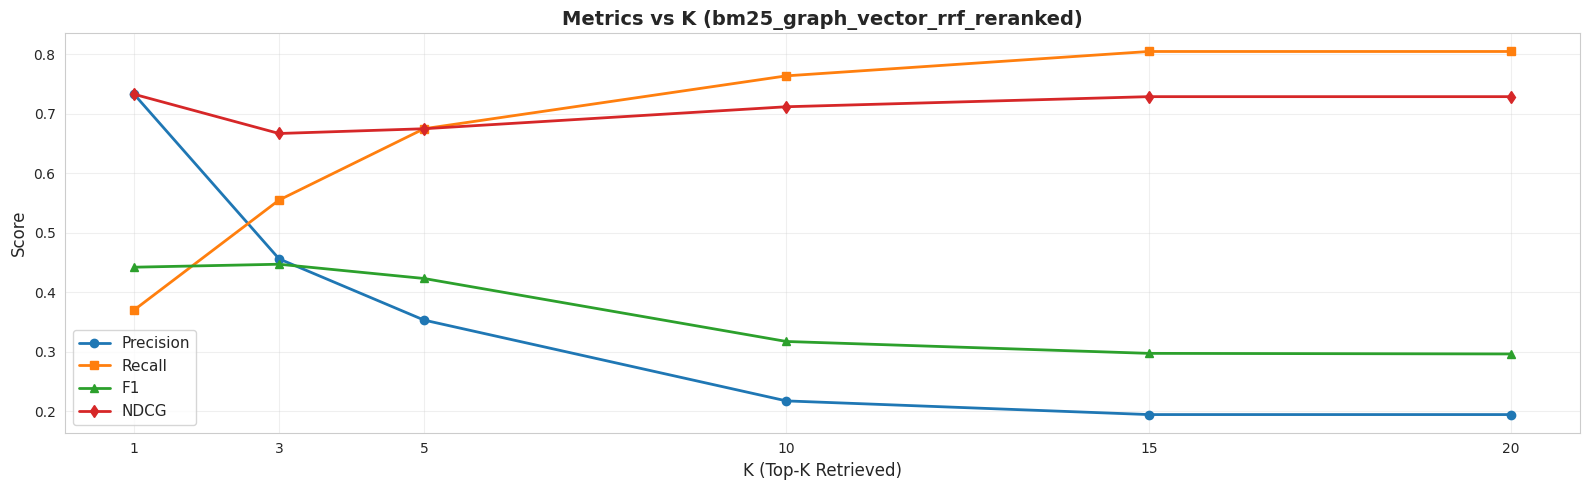

Saved: metrics_vs_k.png


In [12]:
# Plot 1: Precision, Recall, F1 vs K
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
# Element-level metrics
ax.plot(agg_by_k.index, agg_by_k['precision_elements'], marker='o', label='Precision', linewidth=2)
ax.plot(agg_by_k.index, agg_by_k['recall_elements'], marker='s', label='Recall', linewidth=2)
ax.plot(agg_by_k.index, agg_by_k['f1_elements'], marker='^', label='F1', linewidth=2)
ax.plot(agg_by_k.index, agg_by_k['ndcg_elements'], marker='d', label='NDCG', linewidth=2)
ax.set_xlabel('K (Top-K Retrieved)', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Metrics vs K ({ALGORITHM})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(k_values)

plt.tight_layout()
plt.savefig(des /'metrics_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: metrics_vs_k.png")


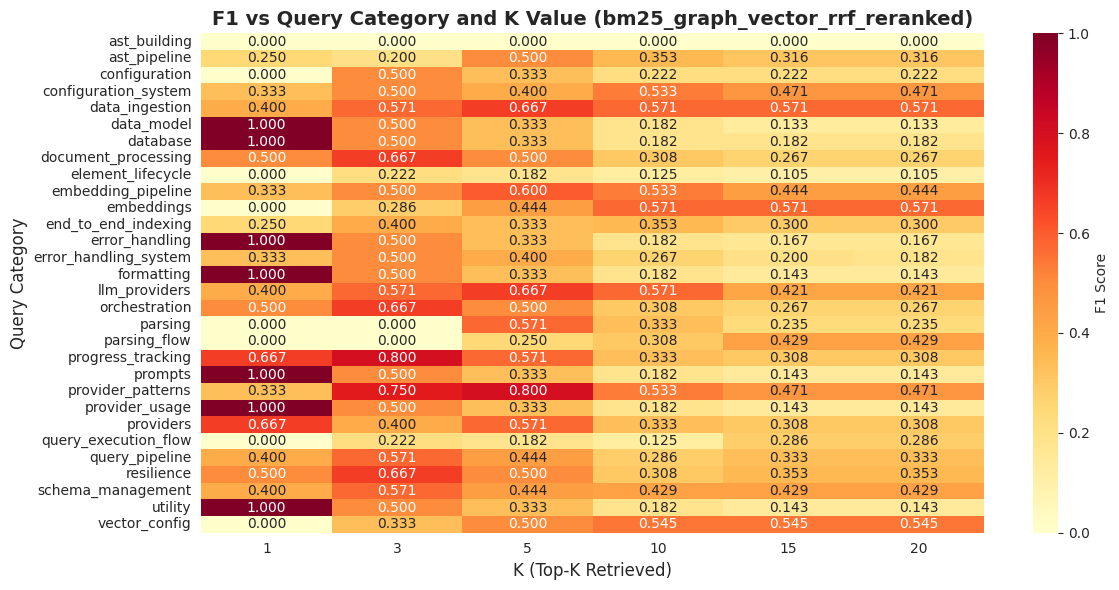

Saved: f1_heatmap.png


In [13]:
# Plot 2: Heatmap of F1 scores by category and K
pivot_f1 = df_results.pivot_table(
    values='f1_elements',
    index='category',
    columns='k',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'F1 Score'})
plt.title(F'F1 vs Query Category and K Value ({ALGORITHM})', fontsize=14, fontweight='bold')
plt.xlabel('K (Top-K Retrieved)', fontsize=12)
plt.ylabel('Query Category', fontsize=12)
plt.tight_layout()
plt.savefig(des/'f1_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: f1_heatmap.png")


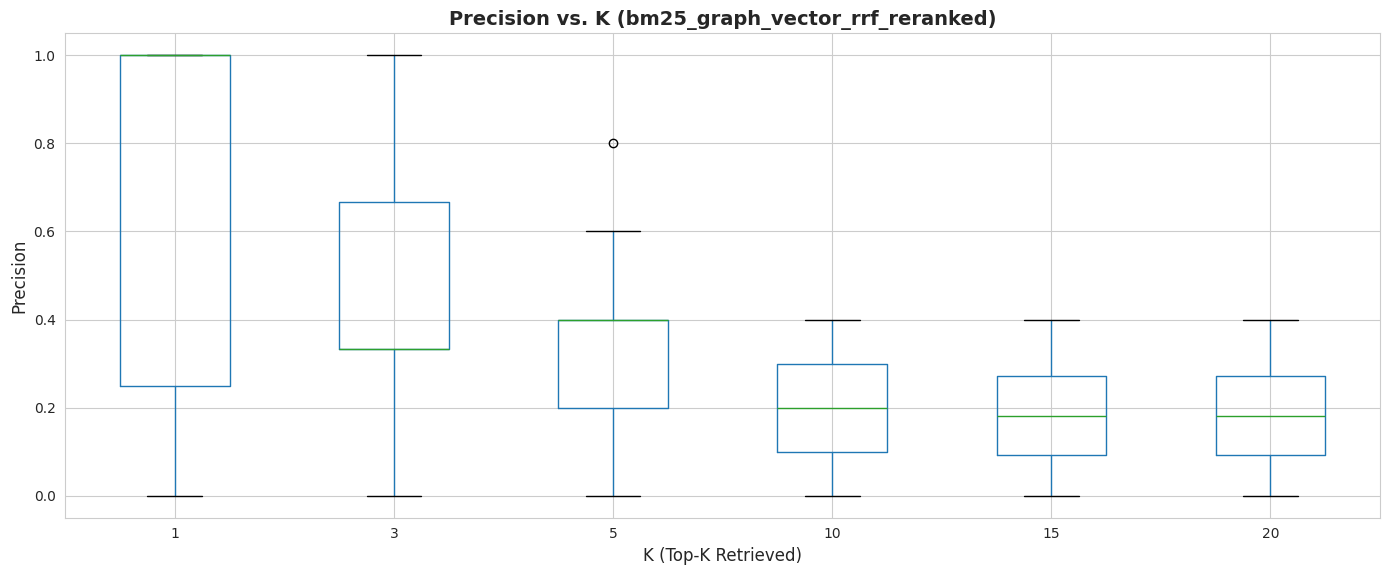

Saved: precision_distribution.png


In [14]:
# Plot 3: Box plot of precision distribution by K
fig, ax = plt.subplots(figsize=(14, 6))
df_results.boxplot(column='precision_elements', by='k', ax=ax)
ax.set_xlabel('K (Top-K Retrieved)', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title(f'Precision vs. K ({ALGORITHM})', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig(des / 'precision_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: precision_distribution.png")


## 8. Best/Worst Queries Analysis


In [15]:
# Find best and worst performing queries at k=5
df_k5 = df_results[df_results['k'] == 5].copy()

# Best queries (by F1)
best_queries = df_k5.nlargest(3, 'f1_elements')[['query', 'category', 'precision_elements', 'recall_elements', 'f1_elements']]
print("\n=== Top 3 Best Performing Queries (k=5) ===")
print(best_queries.to_string(index=False))

# Worst queries (by F1)
worst_queries = df_k5.nsmallest(3, 'f1_elements')[['query', 'category', 'precision_elements', 'recall_elements', 'f1_elements']]
print("\n=== Top 3 Worst Performing Queries (k=5) ===")
print(worst_queries.to_string(index=False))



=== Top 3 Best Performing Queries (k=5) ===
                                                                          query          category  precision_elements  recall_elements  f1_elements
How do the provider registry and factory patterns work for embeddings and LLMs? provider_patterns                 0.8             0.80     0.800000
                      How are different LLM providers managed and instantiated?     llm_providers                 0.6             0.75     0.666667
                     How are code files loaded and processed into the database?    data_ingestion                 0.6             0.75     0.666667

=== Top 3 Worst Performing Queries (k=5) ===
                                                                 query             category  precision_elements  recall_elements  f1_elements
                          How does AST building work for Python files?         ast_building                 0.0         0.000000     0.000000
      How does query execution wo

## 9. Save Results


In [16]:
# Save detailed results
df_results.to_csv(des / 'evaluation_results.csv', index=False)
print("Saved: evaluation_results.csv")

# Save aggregate metrics
agg_by_k.to_csv(des / 'metrics_by_k.csv')
print("Saved: metrics_by_k.csv")

# Save summary report
with open(des / 'evaluation_summary.txt', 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("LucusRAG Evaluation Summary\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Total Queries: {len(test_queries)}\n")
    f.write(f"K Values Tested: {k_values}\n\n")
    
    f.write("Average Metrics by K Value:\n")
    f.write("-" * 80 + "\n")
    f.write(agg_by_k.to_string())
    f.write("\n\n")
    
    f.write("Best Configuration:\n")
    f.write("-" * 80 + "\n")
    best_k = agg_by_k['f1_elements'].idxmax()
    f.write(f"Optimal K: {best_k}\n")
    f.write(f"F1 Score: {agg_by_k.loc[best_k, 'f1_elements']:.3f}\n")
    f.write(f"Precision: {agg_by_k.loc[best_k, 'precision_elements']:.3f}\n")
    f.write(f"Recall: {agg_by_k.loc[best_k, 'recall_elements']:.3f}\n")
    f.write(f"NDCG: {agg_by_k.loc[best_k, 'ndcg_elements']:.3f}\n")

print("Saved: evaluation_summary.txt")
print("\n" + "=" * 80)
print("Evaluation complete! All results saved.")
print("=" * 80)


Saved: evaluation_results.csv
Saved: metrics_by_k.csv
Saved: evaluation_summary.txt

Evaluation complete! All results saved.


## 10. Recommendations

Based on the evaluation results:

1. **Optimal K Value**: Review `metrics_by_k.csv` to find the K value that balances precision and recall
2. **Weak Categories**: Examine categories with low F1 scores in the heatmap
3. **Retrieval Quality**: Use NDCG scores to assess ranking quality
4. **System Tuning**:
   - Adjust similarity threshold in `SimilarityPostprocessor`
   - Experiment with different embedding models
   - Consider query expansion techniques for low-recall queries
   - Add re-ranking layers for better precision
